# Ensemble MH

In [1]:
import matplotlib.pyplot as plt
from mcmc import *
from mcmc_plots import (plot_trace_mcmc, plot_marginal_distributions, 
                       plot_autocorrelations, plot_distribution)
%load_ext autoreload
%autoreload 2

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [3]:
# ------------------------------
# Ensemble MCMC with guided inits
# ------------------------------
import numpy as np
from sklearn.mixture import GaussianMixture
from math import lgamma

# ------------------------------
# Helper: fit a 2-component GMM to x (1D)
# ------------------------------
def fit_gmm_2comp(x, rng_seed=0):
    gm = GaussianMixture(n_components=2, covariance_type='diag', random_state=rng_seed)
    gm.fit(x.reshape(-1,1))
    means = gm.means_.flatten()
    variances = gm.covariances_.flatten()
    weights = gm.weights_.flatten()
    order = np.argsort(means)
    mu1, mu2 = means[order[0]], means[order[1]]
    var1, var2 = variances[order[0]], variances[order[1]]
    w1 = weights[order[0]]
    sigma1, sigma2 = np.sqrt(var1), np.sqrt(var2)
    return {'w1': float(w1), 'mu1': float(mu1), 'mu2': float(mu2),
            'sigma1': float(sigma1), 'sigma2': float(sigma2)}

# ------------------------------
# Build a set of guided initial states
# - uses: percentile init, GMM init, perturbed versions, and some overdispersed
# theta = [w, mu1, delta, sigma1, sigma2]
# ------------------------------
def guided_inits(x, bounds, n_chains=8, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    inits = []
    N = len(x)

    # 1) percentile-based init (robust)
    p25, p75 = np.percentile(x, [25,75])
    mu1_p = p25
    delta_p = max(0.5, p75 - p25)
    w_p = 0.5
    s1_p = 1.0
    s2_p = 1.0
    init_p = np.array([w_p, mu1_p, delta_p, s1_p, s2_p])
    inits.append(init_p)

    # 2) GMM-based init (if GMM fails, fall back to percentile)
    try:
        gmm = fit_gmm_2comp(x, rng_seed= int(rng.integers(0,10000)))
        init_gmm = np.array([gmm['w1'], gmm['mu1'], gmm['mu2'] - gmm['mu1'], gmm['sigma1'], gmm['sigma2']])
    except Exception:
        init_gmm = init_p.copy()
    inits.append(init_gmm)

    # 3) Perturbations around these two (small jitter)
    for base in [init_p, init_gmm]:
        for scale in [0.1, 0.3]:
            jitter = rng.normal(scale=scale, size=base.shape)
            cand = base * (1.0 + jitter)  # multiplicative jitter
            # ensure delta positive, w in (0,1)
            cand[0] = np.clip(cand[0], bounds[0][0]+1e-6, bounds[0][1]-1e-6)
            cand[1] = np.clip(cand[1], bounds[1][0], bounds[1][1])
            cand[2] = np.clip(np.abs(cand[2]), bounds[2][0]+1e-6, bounds[2][1])
            cand[3] = np.clip(cand[3], bounds[3][0], bounds[3][1])
            cand[4] = np.clip(cand[4], bounds[4][0], bounds[4][1])
            inits.append(cand)

    # 4) Overdispersed initials (spread across bounds) - systematic choices
    w_low = np.array([bounds[0][0] + 0.05, bounds[1][0] + 0.1*(bounds[1][1]-bounds[1][0]),
                      0.5, 0.5*bounds[3][1], 0.8*bounds[4][1]])
    w_high = np.array([bounds[0][1] - 0.05, bounds[1][0] + 0.9*(bounds[1][1]-bounds[1][0]),
                       2.0, 0.2*bounds[3][1], 0.9*bounds[4][1]])
    inits.append(np.clip(w_low, [b[0] for b in bounds], [b[1] for b in bounds]))
    inits.append(np.clip(w_high, [b[0] for b in bounds], [b[1] for b in bounds]))

    # 5) If still fewer than desired, generate jittered versions of the best estimates
    i = 0
    while len(inits) < n_chains:
        base = inits[i % len(inits)]
        jitter = rng.normal(scale=0.15, size=base.shape)
        cand = base * (1.0 + jitter)
        cand[0] = np.clip(cand[0], bounds[0][0]+1e-6, bounds[0][1]-1e-6)
        cand[1] = np.clip(cand[1], bounds[1][0], bounds[1][1])
        cand[2] = np.clip(np.abs(cand[2]), bounds[2][0]+1e-6, bounds[2][1])
        cand[3] = np.clip(cand[3], bounds[3][0], bounds[3][1])
        cand[4] = np.clip(cand[4], bounds[4][0], bounds[4][1])
        inits.append(cand)
        i += 1

    # trim/pad to exactly n_chains
    inits = inits[:n_chains]
    return np.array(inits)

# ------------------------------
# Slightly cleaned metropolis-hastings (less verbose, returns acceptance)
# - uses a multivariate normal proposal with given covariance (or default diag)
# ------------------------------
def metropolis_hastings_chain(theta0, x, bounds, rng=None, sigma_logT90=0.0, n=10000,
                              cov_proposal=None, print_every=0):
    """
    theta = [w, mu1, delta, sigma1, sigma2]
    cov_proposal: covariance matrix for the multivariate normal proposal (dxd)
    """
    if rng is None:
        rng = np.random.default_rng()
    theta0 = np.atleast_1d(theta0).astype(np.float64)
    d = theta0.shape[0]

    # default covariance (diagonal tuned proposals)
    if cov_proposal is None:
        scales = np.array([0.02, 0.5, 0.6, 0.25, 0.25])  # adjust if needed
        cov_proposal = np.diag(scales**2)

    samples = np.zeros((n, d), dtype=np.float64)
    logP0 = log_posterior(x, theta0, bounds, sigma_logT90=sigma_logT90)
    cur = theta0.copy()
    accepted = 0

    for i in range(n):
        prop = rng.multivariate_normal(mean=np.zeros(d), cov=cov_proposal)
        cand = cur + prop

        logP_cand = log_posterior(x, cand, bounds, sigma_logT90=sigma_logT90)
        u = rng.random()
        if np.isfinite(logP_cand) and (logP_cand - logP0 > np.log(u)):
            cur = cand
            logP0 = logP_cand
            accepted += 1
        samples[i,:] = cur

        if print_every and (i+1) % print_every == 0:
            print(f"iter {i+1}/{n} | acc_rate {accepted/(i+1):.3f}")

    accept_rate = accepted / float(n)
    return samples, accept_rate

# ------------------------------
# Diagnostics: R-hat (Gelman-Rubin) and ESS (simple average-ACF estimator)
# ------------------------------
def gelman_rubin(chains, burn=0):
    """
    chains: ndarray shape (n_chains, n_samples, n_params)
    return rhat per parameter (array length n_params)
    """
    m, n_all, p = chains.shape
    n = n_all - burn
    if n <= 1:
        raise ValueError("Not enough samples after burnin")
    # use tail n samples
    tail = chains[:, burn:, :]
    # per-parameter
    rhat = np.zeros(p)
    for j in range(p):
        chain_means = tail[:, :, j].mean(axis=1)
        overall_mean = chain_means.mean()
        B = n * np.var(chain_means, ddof=1)
        W = tail[:, :, j].var(axis=1, ddof=1).mean()
        var_hat = ( (n-1)/n ) * W + (1/n) * B
        rhat[j] = np.sqrt(var_hat / W)
    return rhat

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorrelation_1d(x, norm=True):
    x = np.atleast_1d(x)
    n = len(x)
    N = next_pow_two(n)
    f = np.fft.fft(x - np.mean(x), n=2*N)
    acf = np.fft.ifft(f * np.conjugate(f))[: n].real
    acf /= 2*N
    if norm:
        acf /= acf[0]
    return acf

def effective_sample_size(chains, burn=0, max_lag=None):
    """
    chains: (n_chains, n_samples, n_params)
    returns ESS per parameter (approx)
    """
    m, n_all, p = chains.shape
    n = n_all - burn
    tail = chains[:, burn:, :]
    if max_lag is None:
        max_lag = min(1000, n//2)
    ess = np.zeros(p)
    for j in range(p):
        # average autocorrelation across chains for each lag
        rho_mean = np.zeros(max_lag+1)
        for c in range(m):
            acf = autocorrelation_1d(tail[c,:,j])
            L = min(len(acf)-1, max_lag)
            rho_mean[:L+1] += acf[:L+1]
        rho_mean /= m
        # Geyer's initial monotone sequence: sum positive pairs until negative
        # approximate by truncating when rho_mean[k] < 0
        s = 0.0
        for k in range(1, max_lag+1):
            if rho_mean[k] <= 0:
                break
            s += rho_mean[k]
        # calculate ESS
        ess_j = m * n / (1 + 2 * s)
        ess[j] = ess_j
    return ess

# ------------------------------
# Run ensemble helper: create inits, run chains (parallel optional), diagnostics
# ------------------------------
def run_ensemble(x, bounds, n_chains=8, n_steps=20000, rng_seed=1234, cov_proposal=None,
                 print_every=0, parallel=False):
    """
    Returns: dict with 'chains' ndarray (n_chains, n_steps, d), 'accept_rates', 'rhat', 'ess'
    """
    rng = np.random.default_rng(rng_seed)
    inits = guided_inits(x, bounds, n_chains=n_chains, rng=rng)
    d = inits.shape[1]
    chains = np.zeros((n_chains, n_steps, d))
    accept_rates = np.zeros(n_chains)

    if parallel:
        # simple parallel run using multiprocessing
        import multiprocessing as mp
        pool = mp.Pool(processes=min(n_chains, mp.cpu_count()))
        args = [(inits[i], x, bounds, None, 0.0, n_steps, cov_proposal, print_every) for i in range(n_chains)]
        results = pool.starmap(metropolis_hastings_chain, args)
        pool.close(); pool.join()
        for i, (samps, ar) in enumerate(results):
            chains[i,:,:] = samps
            accept_rates[i] = ar
    else:
        for i in range(n_chains):
            print(f"Starting chain {i+1}/{n_chains} with init {inits[i]}")
            samps, ar = metropolis_hastings_chain(inits[i], x, bounds, rng=np.random.default_rng(rng.integers(1e9)),
                                                  sigma_logT90=0.0, n=n_steps, cov_proposal=cov_proposal, print_every=print_every)
            chains[i,:,:] = samps
            accept_rates[i] = ar
            print(f"Chain {i+1} done. acceptance {ar:.3f}\n")

    # diagnostics (use last half as post-burn for rhat and ESS default)
    burn = int(0.2 * n_steps)
    rhat = gelman_rubin(chains, burn=burn)
    ess = effective_sample_size(chains, burn=burn)
    return {'chains': chains, 'inits': inits, 'accept_rates': accept_rates, 'rhat': rhat, 'ess': ess, 'burn': burn}

# ------------------------------
# Small utility to print summary
# ------------------------------
def summarize_ensemble(res):
    chains = res['chains']; burn = res['burn']
    n_chains, n_steps, d = chains.shape
    post = chains[:, burn:, :]
    means = post.mean(axis=(0,1))
    medians = np.median(post.reshape(-1,d), axis=0)
    stds = post.std(axis=(0,1))
    print("Ensemble summary (post-burn):")
    labels = ['w','mu1','delta','sigma1','sigma2']
    for j,label in enumerate(labels):
        print(f" {label:6s} mean={means[j]:.4f} median={medians[j]:.4f} std={stds[j]:.4f}")
    print("R-hat per param:", res['rhat'])
    print("ESS per param:", np.round(res['ess'],1))
    print("Acceptance rates per chain:", np.round(res['accept_rates'],3))

def pooled_cov_from_chains(chains, burn=0, eps=1e-6):
    m, n, d = chains.shape
    tail = chains[:, burn:, :].reshape(-1, d)
    cov = np.cov(tail, rowvar=False)
    scale = (2.38**2) / float(d)
    cov_prop = scale * cov + eps * np.eye(d)
    return cov_prop

def chain_means_zscore(chains, burn=0):
    tail = chains[:, burn:, :]
    means = tail.mean(axis=1)   # (m, p)
    overall = means.mean(axis=0)
    stds = means.std(axis=0, ddof=1)
    z = (means - overall[None,:]) / (stds[None,:] + 1e-12)
    return means, z

def replace_bad_chain_init(inits, chains, bad_idx, bounds, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    m, n, d = chains.shape
    good_idx = [i for i in range(m) if i != bad_idx]
    # pooled mean of posterior (excluding bad chain)
    pooled_mean = chains[good_idx,:, :].reshape(-1,d).mean(axis=0)
    jitter = rng.normal(scale=0.05, size=d)
    new_init = pooled_mean * (1.0 + jitter)
    # ensure validity (delta positive, w in (0,1))
    new_init[0] = np.clip(new_init[0], bounds[0][0]+1e-6, bounds[0][1]-1e-6)
    new_init[1] = np.clip(new_init[1], bounds[1][0], bounds[1][1])
    new_init[2] = np.clip(abs(new_init[2]), bounds[2][0]+1e-6, bounds[2][1])
    new_init[3] = np.clip(new_init[3], bounds[3][0], bounds[3][1])
    new_init[4] = np.clip(new_init[4], bounds[4][0], bounds[4][1])
    inits[bad_idx,:] = new_init
    return inits

# ---------- main automatic repair function ----------
def repair_bad_chains_and_rerun(res, x, bounds, n_steps_rerun=20000, acc_thresh=0.12,
                                zscore_thresh=4.0, rng_seed=999):
    """
    res: output dict from run_ensemble (contains 'chains','inits','accept_rates','burn')
    x: data logT90
    bounds: prior bounds
    Returns: res_new (with updated chains), and report
    """
    rng = np.random.default_rng(rng_seed)
    chains = res['chains']
    inits = res['inits'].copy()
    acc = res['accept_rates'].copy()
    burn = res['burn']
    m, n, d = chains.shape

    # 1) detect bad chains by acceptance rate
    bad_by_acc = np.where(acc < acc_thresh)[0].tolist()

    # 2) detect chains with means that are outliers (z-score)
    means, z = chain_means_zscore(chains, burn=burn)
    # if any chain has |z|>zscore_thresh for any param, flag it
    bad_by_z = []
    for i in range(m):
        if np.any(np.abs(z[i,:]) > zscore_thresh):
            bad_by_z.append(i)

    bad = sorted(set(bad_by_acc + bad_by_z))
    print("Bad chains detected (acc_thresh, z_thresh):", bad, " (by_acc:", bad_by_acc, " by_z:", bad_by_z, ")")

    if len(bad) == 0:
        print("No bad chains detected. Nothing to rerun.")
        return res

    # 3) Build new cov proposal from pooled good chains (if enough good chains)
    good_idx = [i for i in range(m) if i not in bad]
    if len(good_idx) >= 1:
        cov_new = pooled_cov_from_chains(chains[good_idx,:,:], burn=burn)
    else:
        # fallback: empirical cov from all chains but inflate
        cov_new = pooled_cov_from_chains(chains, burn=burn) * 1.5
    print("Using new proposal covariance (shape):", cov_new.shape)

    # 4) replace inits for bad chains and rerun only them
    for bi in bad:
        print(f"Replacing init for chain {bi} and rerunning...")
        inits = replace_bad_chain_init(inits, chains, bi, bounds, rng=rng)
        # run single chain
        samps, ar = metropolis_hastings_chain(inits[bi], x, bounds, rng=np.random.default_rng(rng.integers(1e9)),
                                              sigma_logT90=0.0, n=n_steps_rerun, cov_proposal=cov_new, print_every=0)
        # replace in res
        chains[bi,:,:] = samps
        acc[bi] = ar
        print(f"Chain {bi} rerun done. new acc={ar:.3f}")

    # 5) recompute diagnostics
    res_new = {'chains': chains, 'inits': inits, 'accept_rates': acc, 'burn': burn}
    res_new['rhat'] = gelman_rubin(chains, burn=burn)
    res_new['ess'] = effective_sample_size(chains, burn=burn)
    return res_new

def plot_traces(chains, burn=0, labels=None, figsize=(12, 2.5*5), params_to_plot=None,
                alpha=0.6, linewidth=0.9, legend=True):
    """
    Plot traceplots per parametro per tutte le catene.

    Args:
      chains: ndarray shape (n_chains, n_steps, n_params)
      burn: int, indice di burn-in (linea verticale)
      labels: list of str length n_params (default ['w','mu1','delta','sigma1','sigma2'] truncated)
      figsize: tuple per matplotlib figure size
      params_to_plot: list/iterable di param indices da plottare (default None => tutti)
      alpha, linewidth: grafica
      legend: True/False mostra legenda nella prima riga

    Usage:
      plot_traces(res['chains'], burn=res['burn'])
    """
    chains = np.asarray(chains)
    if chains.ndim != 3:
        raise ValueError("chains must be shape (n_chains, n_steps, n_params)")

    n_chains, n_steps, n_params = chains.shape

    if params_to_plot is None:
        params = list(range(n_params))
    else:
        params = list(params_to_plot)

    if labels is None:
        default_labels = ['w','mu1','delta','sigma1','sigma2']
        labels = default_labels[:n_params]

    n_plots = len(params)
    fig, axes = plt.subplots(n_plots, 1, figsize=figsize, sharex=True)
    if n_plots == 1:
        axes = [axes]

    x = np.arange(n_steps)
    for ax_idx, param_idx in enumerate(params):
        ax = axes[ax_idx]
        for c in range(n_chains):
            ax.plot(x, chains[c, :, param_idx], alpha=alpha, linewidth=linewidth,
                    label=(f'chain {c+1}' if (legend and ax_idx == 0) else None))
        # burn line
        if burn is not None and burn > 0 and burn < n_steps:
            ax.axvline(burn, color='k', linestyle='--', alpha=0.6)
        ax.set_ylabel(labels[param_idx])
        # show legend only on top plot to avoid clutter
        if legend and ax_idx == 0:
            ax.legend(ncol=min(4, n_chains), fontsize=8, loc='upper right')
        # improve layout
        ax.grid(alpha=0.15)

    axes[-1].set_xlabel('iteration')
    plt.tight_layout()
    plt.show()

In [4]:
DATA_PATH = "GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)
logT90       = arr[:,0]
sigma_logT90 = arr[:,1]

In [6]:
bounds = [
    [0.05, 0.95],     # w
    [-4, 7],        # mu1 (ln s)
    [0.0, 10.0],    # delta = mu2 - mu1
    [1e-1, 6.0],    # sigma1 (in log-space)
    [1e-1, 6.0]     # sigma2
]

covariance = np.array(([ 1.16001274e-04, 4.34444634e-05, -8.75870281e-06, 3.74859215e-05, -2.68890398e-05],
                           [ 4.34444634e-05, 1.30336403e-03, -1.12672730e-03, 2.51966524e-04, -1.73614797e-04],
                           [-8.75870281e-06, -1.12672730e-03, 1.90314140e-03, -9.62649007e-05, 8.67849825e-06],
                           [ 3.74859215e-05, 2.51966524e-04, -9.62649007e-05, 8.14646898e-04, -1.35645581e-04],
                           [-2.68890398e-05, -1.73614797e-04, 8.67849825e-06, -1.35645581e-04, 5.28118669e-04]))

res = run_ensemble(logT90, bounds, n_chains=8, n_steps=20000, rng_seed=1234, 
             cov_proposal=covariance, print_every=0, parallel=True)

In [7]:
summarize_ensemble(res)

Ensemble summary (post-burn):
 w      mean=0.3983 median=0.3226 std=0.2088
 mu1    mean=0.1346 median=-0.1680 std=0.8602
 delta  mean=3.5473 median=3.7240 std=0.6532
 sigma1 mean=1.4966 median=1.4286 std=0.2218
 sigma2 mean=1.5571 median=0.9937 std=1.5097
R-hat per param: [12.01157921  7.4761887   1.62418321  2.94349291 13.69306238]
ESS per param: [1371.5  831.8  380.9  872.2  544.6]
Acceptance rates per chain: [0.43  0.436 0.438 0.441 0.437 0.425 0.43  0.086]


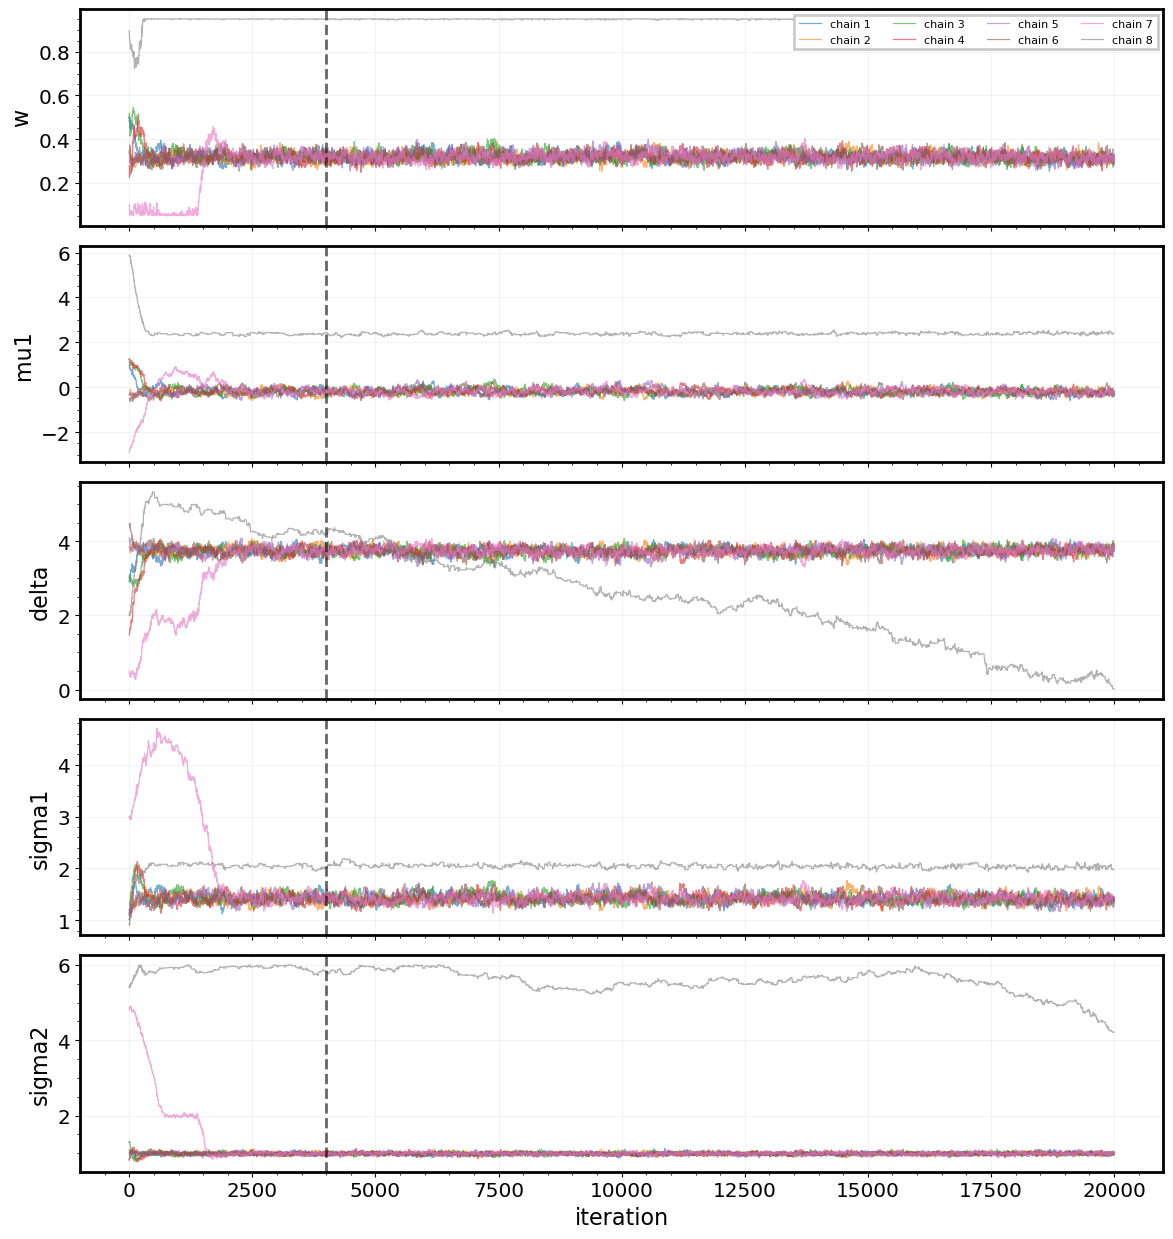

In [8]:
plot_traces(res['chains'], burn=res['burn'])

In [26]:
res2 = repair_bad_chains_and_rerun(res, logT90, bounds, n_steps_rerun=20000, acc_thresh=0.12, zscore_thresh=4.0)
summarize_ensemble(res2)

Bad chains detected (acc_thresh, z_thresh): [7]  (by_acc: [7]  by_z: [] )
Using new proposal covariance (shape): (5, 5)
Replacing init for chain 7 and rerunning...
Chain 7 rerun done. new acc=0.219
Ensemble summary (post-burn):
 w      mean=0.3198 median=0.3186 std=0.0223
 mu1    mean=-0.1839 median=-0.1951 std=0.1512
 delta  mean=3.7319 median=3.7418 std=0.1254
 sigma1 mean=1.4234 median=1.4139 std=0.1092
 sigma2 mean=0.9899 median=0.9892 std=0.0378
R-hat per param: [1.00157211 1.00357851 1.00464319 1.00418148 1.00056919]
ESS per param: [1006.8  720.2  757.6  777.4 1726.2]
Acceptance rates per chain: [0.435 0.433 0.43  0.438 0.431 0.433 0.412 0.219]


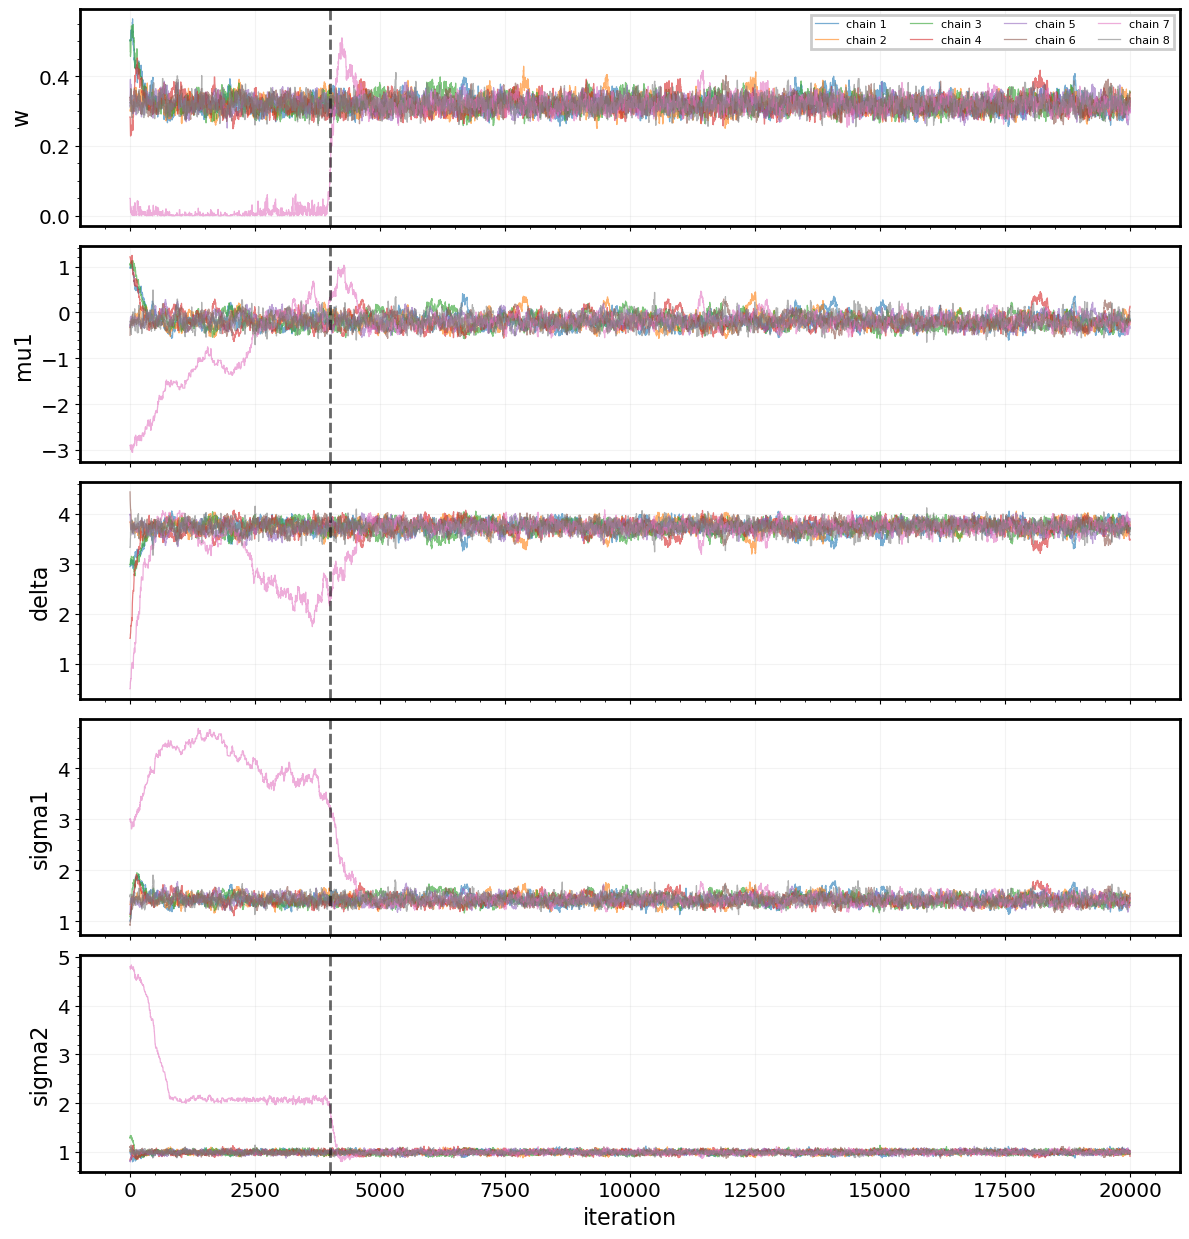

In [27]:
plot_traces(res2['chains'], burn=res2['burn'])

## Version 2

In [13]:
import numpy as np
from mcmc import metropolis_hastings  # assume this is available

def _clip_theta_to_bounds(theta, bounds):
    """Clip a theta vector to bounds and enforce 0<w<1 and delta>=0."""
    theta = np.array(theta, dtype=float)
    # w: index 0 (keep strictly inside (0,1))
    theta[0] = np.clip(theta[0], bounds[0][0] + 1e-6, bounds[0][1] - 1e-6)
    # mu1: index 1
    theta[1] = np.clip(theta[1], bounds[1][0], bounds[1][1])
    # delta: index 2, must be >= lower bound
    theta[2] = np.clip(theta[2], bounds[2][0] + 1e-6, bounds[2][1])
    # sigma1/sigma2: indices 3,4 (positive)
    theta[3] = np.clip(theta[3], bounds[3][0], bounds[3][1])
    theta[4] = np.clip(theta[4], bounds[4][0], bounds[4][1])
    return theta

def generate_nearby_inits(theta_center, bounds, rng=None, n_chains=8, scale=0.05):
    """
    Generate n_chains initial thetas near theta_center, respecting bounds.
    scale: fraction of (bound range) used as std for perturbations (small => very close).
    Returns array shape (n_chains, d).
    """
    if rng is None:
        rng = np.random.default_rng()
    theta_center = np.atleast_1d(theta_center).astype(float)
    d = theta_center.shape[0]
    inits = np.zeros((n_chains, d), dtype=float)

    # precompute ranges and log-ranges
    ranges = np.array([b[1] - b[0] for b in bounds], dtype=float)
    # for positive variables (sigma), use log-range
    log_bounds = []
    for i in (3,4):
        lo, hi = bounds[i]
        # protect against non-positive, but your bounds have lo>0
        log_bounds.append((np.log(max(lo,1e-12)), np.log(max(hi,1e-12))))

    for k in range(n_chains):
        th = theta_center.copy()

        # w: additive normal small noise, then clip inside (0,1)
        w_std = max(1e-3, scale * ranges[0])
        th[0] = rng.normal(th[0], w_std)
        th[0] = np.clip(th[0], bounds[0][0] + 1e-6, bounds[0][1] - 1e-6)

        # mu1: additive noise relative to mu-range
        mu1_std = max(1e-3, scale * ranges[1])
        th[1] = rng.normal(th[1], mu1_std)
        th[1] = np.clip(th[1], bounds[1][0], bounds[1][1])

        # delta: propose additive noise but ensure >= lower bound
        delta_std = max(1e-3, scale * ranges[2])
        delta_prop = rng.normal(th[2], delta_std)
        # reflect negative perturbations to keep positive-ish
        if delta_prop < bounds[2][0] + 1e-6:
            delta_prop = bounds[2][0] + abs(delta_prop - (bounds[2][0] + 1e-6))
        th[2] = np.clip(delta_prop, bounds[2][0] + 1e-6, bounds[2][1])

        # sigma1 and sigma2: perturb in log-space (more reasonable for scale parameters)
        for idx_i, (log_lo, log_hi) in zip([3,4], log_bounds):
            log_sigma0 = np.log(max(theta_center[idx_i], bounds[idx_i][0] + 1e-12))
            # use a relative std in log-space
            log_std = max(1e-3, scale * (log_hi - log_lo))
            log_prop = rng.normal(log_sigma0, log_std)
            sigma_prop = float(np.exp(log_prop))
            th[idx_i] = np.clip(sigma_prop, bounds[idx_i][0], bounds[idx_i][1])

        # final clip to bounds & ensure constraints
        th = _clip_theta_to_bounds(th, bounds)
        inits[k, :] = th

    return inits

def run_ensemble_chains(theta_center, x, bounds, rng=None,
                        n_chains=8, n_steps=50000, cov_prop=None,
                        sigma_logT90=0.0, scale=0.05, verbose=True):
    """
    Generate n_chains initial points near theta_center and run metropolis_hastings
    for each chain. Returns dict with keys:
      'theta0s' : (n_chains, d) initial points
      'chains'  : list of arrays (n_steps, d)
      'acc_rates': list of empirical acceptance rates per chain
    cov_prop: initial proposal covariance passed to metropolis_hastings via init_cov.
              If None, metropolis_hastings will use its default small diag.
    """
    if rng is None:
        rng = np.random.default_rng()

    theta_center = np.atleast_1d(theta_center).astype(float)
    inits = generate_nearby_inits(theta_center, bounds, rng=rng, n_chains=n_chains, scale=scale)

    chains = []
    acc_rates = []

    for k in range(n_chains):
        theta0_k = inits[k].copy()
        if verbose:
            print(f"Starting chain {k+1}/{n_chains}, theta0 = {theta0_k}")

        # run the chain (metropolis_hastings prints progress and final acceptance)
        chain_samples = metropolis_hastings(theta0_k, x, bounds,
                                           init_cov=cov_prop, rng=rng,
                                           sigma_logT90=sigma_logT90, n=n_steps)
        # chain_samples shape (n_steps, d)
        chains.append(chain_samples)

        # compute empirical acceptance rate from samples: fraction of transitions where sample changed
        if chain_samples.shape[0] >= 2:
            diffs = np.any(chain_samples[1:, :] != chain_samples[:-1, :], axis=1)
            emp_acc = float(np.sum(diffs)) / float(diffs.size)
        else:
            emp_acc = 0.0
        acc_rates.append(emp_acc)
        if verbose:
            print(f"  empirical acceptance (from samples) = {emp_acc:.3f}")

    return {
        'theta0s': inits,
        'chains': chains,
        'acc_rates': acc_rates
    }

In [14]:
rng = np.random.default_rng(1234)
theta_center = init_theta_from_data(logT90, bounds)  # il valore iniziale che usi già (es. init_theta_from_data)

# la cov stimata dall'adapt phase; se None, MH userà proposal default
cov_prop = np.array(
    ([ 1.18469911e-04,  5.41824007e-05, -1.24522133e-05,  4.46707267e-05, -4.03425662e-05],
     [ 5.41824007e-05,  1.36698957e-03, -1.17677392e-03,  2.48022150e-04, -1.88421312e-04],
     [-1.24522133e-05, -1.17677392e-03,  1.95074293e-03, -1.07649682e-04, 3.79691082e-05],
     [ 4.46707267e-05,  2.48022150e-04, -1.07649682e-04,  8.16064977e-04, -1.22967936e-04],
     [-4.03425662e-05, -1.88421312e-04,  3.79691082e-05, -1.22967936e-04, 5.72060434e-04]))   

res = run_ensemble_chains(theta_center, logT90, bounds, rng=rng,
                          n_chains=8, n_steps=50000, cov_prop=cov_prop,
                          sigma_logT90=sigma_logT90, scale=0.05, verbose=True)

# access:
theta0s = res['theta0s']      # shape (8,5)
chains  = res['chains']       # list of 8 arrays (n_steps,5)
accs    = res['acc_rates']    # list of 8 empirical acceptance rates

Starting chain 1/8, theta0 = [0.42782734 0.99995482 3.31183115 1.03173699 1.19342014]
iteration 0: acceptance 0.0
iteration 2500: acceptance 0.434052757793765
iteration 5000: acceptance 0.4342263094762095
iteration 7500: acceptance 0.42788589709410824
iteration 10000: acceptance 0.42391521695660866
iteration 12500: acceptance 0.4256119020956647
iteration 15000: acceptance 0.42640981202506334
iteration 17500: acceptance 0.42406582104902296
iteration 20000: acceptance 0.4232076792320768
iteration 22500: acceptance 0.422184694693805
iteration 25000: acceptance 0.42116630669546434
iteration 27500: acceptance 0.42113300850847213
iteration 30000: acceptance 0.4218052129858009
iteration 32500: acceptance 0.4214509876315304
iteration 35000: acceptance 0.42283298097251587
iteration 37500: acceptance 0.4243240360514106
iteration 40000: acceptance 0.42377881105944704
iteration 42500: acceptance 0.42407416121594277
iteration 45000: acceptance 0.42422558997377896
iteration 47500: acceptance 0.42438

In [37]:
from matplotlib import cm
import math

def _ensure_chains_array(chains):
    """
    Normalizza l'input: accetta
      - list of arrays (n_steps, d)
      - array (n_chains, n_steps, d)
    Restituisce array (n_chains, n_steps, d).
    """
    if isinstance(chains, np.ndarray):
        if chains.ndim == 3:
            return chains.copy()
        else:
            raise ValueError("If chains is ndarray it must be shape (n_chains, n_steps, d).")
    # assume list
    chains_list = list(chains)
    # check shapes
    shapes = [c.shape for c in chains_list]
    # allow chains given as (n_steps, d)
    n_chains = len(chains_list)
    n_steps = chains_list[0].shape[0]
    d = chains_list[0].shape[1]
    for c in chains_list:
        if c.shape != (n_steps, d):
            raise ValueError("All chains must have same shape (n_steps, d). Found shapes: " + str(shapes))
    arr = np.stack(chains_list, axis=0)  # (n_chains, n_steps, d)
    return arr


def moving_average(x, window=51, pad_mode='reflect'):
    """
    Centered moving average with proper edge handling via padding.
    - window: desired window length (will be made odd if even).
    - pad_mode: padding mode for np.pad ('reflect', 'edge', 'symmetric', ...).
    Returns array same shape as x.
    """
    x = np.asarray(x, dtype=float)
    if window <= 1:
        return x.copy()

    # ensure odd window for true centering
    if window % 2 == 0:
        window += 1

    pad = window // 2
    # pad the signal (reflect avoids zero-padding artefacts)
    x_padded = np.pad(x, pad, mode=pad_mode)
    kernel = np.ones(window, dtype=float) / float(window)
    # use 'valid' so that result length is len(x_padded) - window + 1 == len(x)
    out = np.convolve(x_padded, kernel, mode='valid')
    return out

def plot_trace_ensemble(chains, param_names=None, burnin=0, figsize=(12,9),
                        ma_window=51, colors=None, savepath=None, show=True):
    """
    Plot trace plots for an ensemble of chains.

    Parameters
    ----------
    chains : list of arrays or ndarray
        list of chain arrays [(n_steps,d), ...] or ndarray (n_chains, n_steps, d).
    param_names : list[str], optional
        names for parameters (length d). If None, defaults to ['p0','p1',...].
    burnin : int
        number of initial samples to mark as burnin (will be shaded).
    figsize : tuple
    ma_window : int
        window size for moving average (set <=1 to disable).
    colors : list-like or None
        colors for the chains (will cycle if fewer than n_chains).
    savepath : str or None
        if provided, the figure is saved to this path.
    show : bool
        whether to call plt.show() at the end.
    """
    chains_arr = _ensure_chains_array(chains)
    n_chains, n_steps, d = chains_arr.shape

    if param_names is None:
        param_names = [f"p{i}" for i in range(d)]
    if len(param_names) != d:
        raise ValueError("param_names length must equal number of parameters d")

    # prepare colors
    cmap = cm.get_cmap('tab10')
    if colors is None:
        colors = [cmap(i % 10) for i in range(n_chains)]
    else:
        # cycle/truncate
        colors = list(colors)
        if len(colors) < n_chains:
            colors = [colors[i % len(colors)] for i in range(n_chains)]

    # create subplots: one row per parameter
    fig, axes = plt.subplots(d, 1, figsize=figsize, sharex=True)
    if d == 1:
        axes = [axes]

    x = np.arange(n_steps)

    for j in range(d):
        ax = axes[j]
        # plot each chain
        for k in range(n_chains):
            series = chains_arr[k, :, j]
            ax.plot(x, series, lw=0.8, color=colors[k], alpha=0.45, label=f"chain {k+1}" if j==0 else None)
            if ma_window and ma_window > 1:
                ma = moving_average(series, window=ma_window)
                ax.plot(x, ma, lw=1.5, color=colors[k], alpha=0.9)

        # shade burnin region
        if burnin > 0:
            ax.axvspan(0, min(burnin, n_steps), color='0.9', zorder=-1)

        # axis labels and title with R-hat
        ax.set_ylabel(param_names[j])

        # grid and aesthetics
        ax.grid(True, lw=0.3, alpha=0.6)

    axes[-1].set_xlabel("iteration")

    # legend only once
    handles = [plt.Line2D([0],[0], color=colors[i], lw=2) for i in range(min(n_chains,10))]
    labels = [f"chain {i+1}" for i in range(min(n_chains,10))]
    
    # compute number of columns to split legend into two rows:
    ncol = int(math.ceil(n_chains / 2.0))
    # limit columns to reasonable maximum (optional), e.g. 8
    ncol = min(ncol, 8)

    # add legend ABOVE first subplot, splitted in two rows by using ncol = ceil(n_chains/2)
    fig.legend(handles, labels, loc='upper center', ncol=ncol,
               frameon=False, bbox_to_anchor=(0.5, 1.06), fontsize=15)

    plt.tight_layout()
    if savepath is not None:
        fig.savefig(savepath, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    plt.close(fig)

/tmp/ipykernel_7402/833302647.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


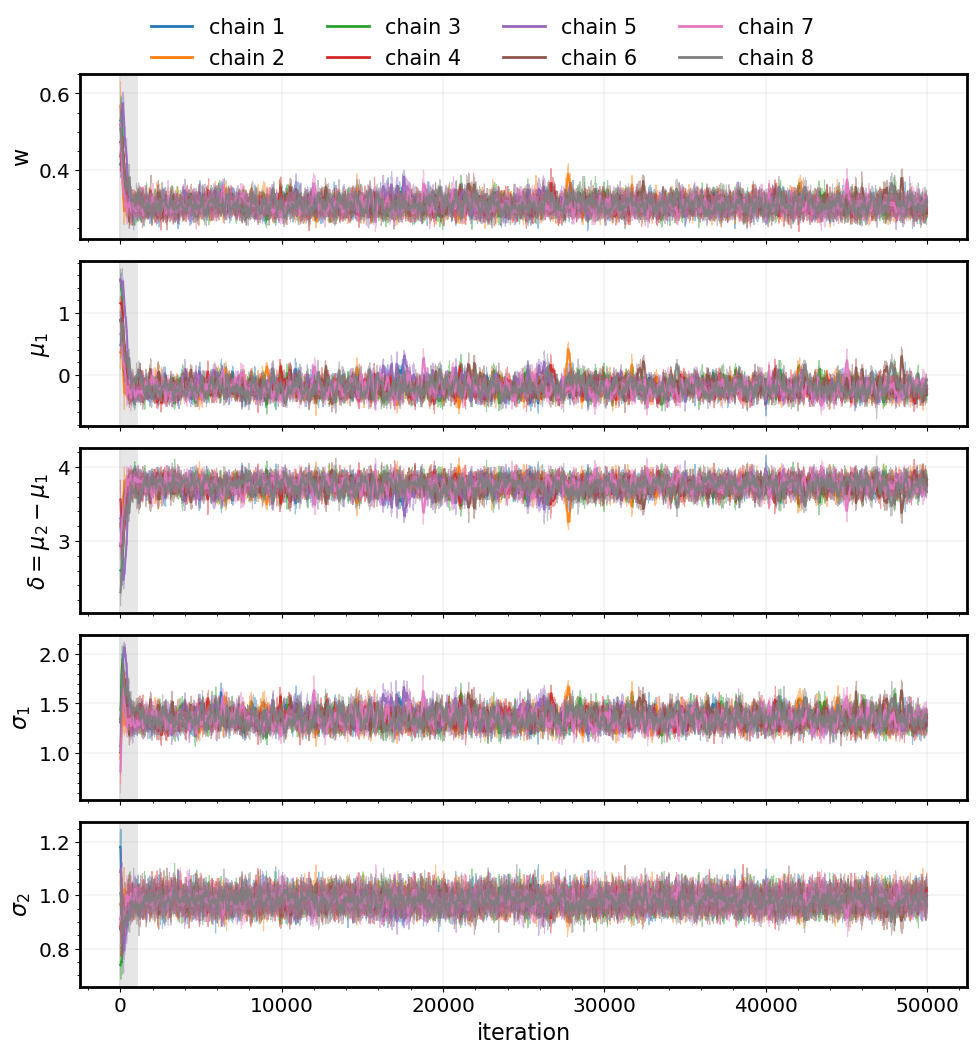

In [38]:
chains = res['chains']            # list di 8 arrays (n_steps, d)
param_names = ['w','$\mu_1$','$\delta = \mu_2 - \mu_1$','$\sigma_1$','$\sigma_2$']
plot_trace_ensemble(chains, param_names=param_names, burnin=1000, ma_window=101,
                    figsize=(10,10), savepath=None)